In [120]:
import matplotlib.pyplot as plt
import argparse
import os
import sys
from os.path import join as pjoin
import numpy as np
import time
import datetime
import platform
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.optim.lr_scheduler as lr_scheduler
from torchvision import datasets
from sklearn.metrics import average_precision_score as avg_precision
from collections import OrderedDict
import pickle
from matplotlib import cm
#import graphdata
#from image_superpixels import ImageSP
#import models as my_models
#import utils
#import pascal_loader
import networkx as nx
import cv2
from scipy.spatial.distance import cdist
#from sklearn.manifold import TSNE
import importlib
#import visdom
import matplotlib as mlp
from sklearn.metrics import roc_auc_score, roc_curve
import seaborn as sns
import chebygin as my_models
import importlib
from utils import *
from sklearn.metrics import roc_auc_score, roc_curve
import graphdata

In [2]:
def read_results(results_dir, epoch=50):
    acc = []
    for f in os.listdir(results_dir):
        with open(pjoin(results_dir, f), 'r') as fp:
            lines = fp.readlines()#[-1]        
        
        try:
            if lines[-1].find('cross validation avg acc') >= 0:
                s = lines[-1]
                pos1 = s.find(':')
                acc.append(float(s[pos1+1:s[pos1:].find('(') + pos1]))
            else:
                s = list(filter(lambda l: l.find('Test set (epoch %d):' % epoch) >= 0, lines))[0]
                pos1 = s.find(':')
                pos2 = pos1 + s[pos1:].find('%')
                pos1 = pos1 + s[pos1:].find('(')
                acc.append(float(s[pos1+1:pos2]))
        except:
            continue
    print(len(acc), np.mean(acc), np.std(acc), np.min(acc), np.max(acc))

In [3]:
read_results('/export/mlrg/bknyazev/projects/graph_nn/repeats/mcheb_paper/')

10 76.04583333333333 0.499241559121176 75.27380952380953 77.10714285714286


# COLLAB

In [75]:
[1e-4, 1e-3, 2e-3, 5e-3, 1e-2, 3e-2, 5e-2, 1e-1]

[0.0001, 0.001, 0.002, 0.005, 0.01, 0.03, 0.05, 0.1]

In [72]:
read_results('/export/mlrg/bknyazev/projects/graph_attention_pool/results/collab_global_max/')

10 65.895 3.0055423803366996 57.36 69.07


In [99]:
read_results('/export/mlrg/bknyazev/projects/graph_attention_pool/results/collab_unsup_10fold_fc32/')

7 64.37285714285714 3.218037175873847 56.71 66.8


In [74]:
#read_results('/export/mlrg/bknyazev/projects/graph_attention_pool/results/collab_wsup_5fold_88nodes/')

In [97]:
read_results('/export/mlrg/bknyazev/projects/graph_attention_pool/results/collab_wsup_5fold/')

7 60.79428571428572 4.018250710882811 54.73 65.87


In [96]:
read_results('/export/mlrg/bknyazev/projects/graph_attention_pool/results/collab_wsup_10fold_fc32/')

1 60.49 0.0 60.49 60.49


# PROTEINS

In [40]:
read_results('/export/mlrg/bknyazev/projects/graph_attention_pool/results/proteins_global_max/')

10 72.691 1.5268100733228065 68.68 74.06


In [92]:
read_results('/export/mlrg/bknyazev/projects/graph_attention_pool/results/proteins_unsup_10fold/')

10 76.36200000000001 0.4289009209596077 75.53 77.0


In [91]:
read_results('/export/mlrg/bknyazev/projects/graph_attention_pool/results/proteins_wsup_5fold/')

10 76.136 0.9321072899618367 74.39 77.98


In [101]:
read_results('/export/mlrg/bknyazev/projects/graph_attention_pool/results/proteins_wsup_10fold/')

7 76.39285714285714 0.8478664700413668 75.37 77.81


# DD - 200

In [63]:
read_results('/export/mlrg/bknyazev/projects/graph_attention_pool/results/dd_200nodes_global_max/')

10 31.453000000000003 3.977773372126672 25.28 37.29


In [64]:
read_results('/export/mlrg/bknyazev/projects/graph_attention_pool/results/dd_unsup_200nodes_5fold/')

10 57.333000000000006 18.045085231164744 21.37 67.74


In [65]:
read_results('/export/mlrg/bknyazev/projects/graph_attention_pool/results/dd_unsup_200nodes_10fold/')

10 46.271 20.370703694276248 21.37 65.22


In [94]:
read_results('/export/mlrg/bknyazev/projects/graph_attention_pool/results/dd_wsup_200nodes_5fold/')

4 41.165 17.067058182358203 21.37 63.13


In [95]:
read_results('/export/mlrg/bknyazev/projects/graph_attention_pool/results/dd_unsup_200nodes_10fold_fc32/')

9 52.84 14.327860195359872 31.01 70.81


In [117]:
read_results('/export/mlrg/bknyazev/projects/graph_attention_pool/results/dd_wsup_200nodes_10fold_fc32/')

1 65.64 0.0 65.64 65.64


# DD - 300

In [86]:
read_results('/export/mlrg/bknyazev/projects/graph_attention_pool/results/dd_300nodes_global_max/')

10 73.6 2.0625178787103917 68.88 77.29


In [87]:
read_results('/export/mlrg/bknyazev/projects/graph_attention_pool/results/dd_unsup_300nodes_5fold/')

10 77.361 1.249731571178387 75.22 79.06


In [88]:
read_results('/export/mlrg/bknyazev/projects/graph_attention_pool/results/dd_unsup_300nodes_10fold/')

10 76.87299999999998 1.6824924962685572 72.86 78.76


In [96]:
read_results('/export/mlrg/bknyazev/projects/graph_attention_pool/results/dd_unsup_300nodes_10fold_fc32/')

6 77.82666666666667 1.4288651285392777 75.07 79.06


In [4]:
device = 'cpu'
def load_model(model_path, N_nodes_max, in_features=1, out_features=2, my_models=my_models):
    importlib.reload(my_models)
    import chebygin as my_models

    state = torch.load(model_path, map_location=lambda storage, loc: storage)
    print(state['args'].filter_scale)
    model = my_models.ChebyGIN(in_features=in_features,
                              out_features=out_features,
                              K=state['args'].filter_scale,
                              filters=state['args'].filters,
                              dropout=0.1,
                              n_hidden=state['args'].n_hidden,
                              aggregation=state['args'].aggregation,
                              pool=state['args'].pool,
                              pool_arch=state['args'].pool_arch)
    #     print(state['state_dict'])
    print(model)
    model.train()
    print('model capacity: %d' %
          np.sum([np.prod(p.size()) if p.requires_grad else 0 for p in model.parameters()]))

    model.eval()

    try:
        model.load_state_dict(state['state_dict'])
    except Exception as e:
        print('ERROR!!!')
        print(e)
        raise
    model.eval()
    model.to(device)
    print(model)
    return model


In [5]:
def get_graph(data_test, index, draw=True):
    A = data_test.adj_list[index]
    #print(data_test.features_onehot[index].shape, A.shape)
    G = nx.from_numpy_array(A)
    pos = nx.spring_layout(G)
    if draw:
        nx.draw(G, pos, node_size=200, node_color=np.ones(3), edgecolors=np.zeros(3))
        plt.show()
        print('label', data_test.labels[index])
    return A, G, pos

# PROTEINS

In [102]:
datareader = graphdata.DataReader(data_dir='/mnt/data/bknyazev/data/graph_data/PROTEINS',
                                  rnd_state=np.random.RandomState(6149),
                                  N_nodes=25,
                                  use_cont_node_attr=False,
                                  folds=10)
data_train = graphdata.GraphData(datareader, 0, split='train_val')
data_test = graphdata.GraphData(datareader, 0, split='test')

N nodes avg/std/min/max: 	39.06/45.76/4/620
N edges avg/std/min/max: 	72.82/84.60/5/1049
Node degree avg/std/min/max: 	3.73/1.15/0/25
Node features dim: 		3
N classes: 			2
Classes: 			[0 1]
Class 0: 			663 samples
Class 1: 			450 samples
feature 0, count 21151/43471
feature 1, count 20931/43471
feature 2, count 1389/43471
548/1113 graphs with at least 25 nodes
generating 10-fold cross-validation splits
0 450 50
1 450 50
2 450 50
3 450 50
4 450 50
5 450 50
6 450 50
7 450 50
8 450 50
9 450 50
TRAIN_VAL: 500/1113
Class 0: 			209 samples
Class 1: 			291 samples
TEST: 613/1113
Class 0: 			454 samples
Class 1: 			159 samples


In [103]:
with open('/mnt/data/bknyazev/checkpoints/TU_alpha_WS_test_seed6149_orig.pkl', 'rb') as f:
    attn_WS = pickle.load(f)
len(attn_WS)    

613

In [127]:
# /export/mlrg/bknyazev/projects/XAI/Model/graph_examples/results/proteins/attention_25/wsup_10/K3_f64_64_64_lr0.001_proj4/sup_p0.1_K3_f64_50epochs_shape_split_25nodes_lr0.001_seed468.log
#model = load_model('/mnt/data/bknyazev//checkpoints/checkpoint_PROTEINS_GPU10_764088_fold0_epoch50.pth.tar', 620, 3)

# /export/mlrg/bknyazev/projects/graph_attention_pool/results/proteins_wsup_10fold/proteins_wsup_10fold_cv_seed6149.log
model_wsup = load_model('/mnt/data/bknyazev/checkpoints//checkpoint_TU_ws13.cfs.uoguelph.ca_445197_epoch50_seed0006149.pth.tar', 620, 3)
thresh = 0.002

model_global = load_model('/mnt/data/bknyazev/checkpoints//checkpoint_TU_GPU9_747767_epoch50_seed0006149.pth.tar', 620, 3)
model_unsup = load_model('/mnt/data/bknyazev/checkpoints//checkpoint_TU_GPU9_472105_epoch50_seed0006149.pth.tar', 620, 3)
thresh_unsup = 0.005

3
ChebyGINLayer torch.Size([64, 9]) tensor([0.6851, 0.5041, 0.4850, 0.6056, 0.6196, 0.6702, 0.4691, 0.7030, 0.4538,
        0.4781], grad_fn=<SliceBackward>)
ChebyGINLayer torch.Size([64, 192]) tensor([0.5837, 0.5832, 0.5799, 0.5800, 0.5372, 0.5729, 0.5550, 0.5581, 0.5903,
        0.5915], grad_fn=<SliceBackward>)
p values [ 0.5906252  -0.9885852  -0.35449487  0.69860256  1.1907849  -0.6437086
  0.09029202 -0.06795606 -0.9113399  -1.6740767   0.04277126  0.9958773
  0.28116432  0.2171862  -1.0144241  -1.4679586  -2.0639164  -1.5372034
 -0.71696943  0.22693421 -1.6743429   1.0812439   0.65595746 -0.15153529
 -0.5081396  -1.6130735  -0.8694106  -1.4706012  -2.2125268   0.34819263
  1.9122041   0.1377709  -0.14828981  0.8796104  -1.0600604   0.14028393
 -2.3769562  -0.17999057  0.71831995 -0.2138341  -0.12112031 -0.65734893
  0.1676942   1.0918618   1.1627105   0.7895472  -1.8760945  -0.6632903
  0.03100179  0.87456715  1.6030649   0.22781016  0.28009975  0.3470004
 -0.94305885 -0.3578473

In [122]:
pred_wsup, pred_unsup, pred_global, alpha_wsup, alpha_unsup = [], [], [], [], []
for index in range(len(data_test.adj_list)):
    A = data_test.adj_list[index]
    n = A.shape[0]
    data = [torch.from_numpy(data_test.features_onehot[index]).unsqueeze(0).float().to(device).expand(2, -1, -1),
                torch.from_numpy(A).unsqueeze(0).float().to(device).to(device).expand(2, -1, -1),
                torch.ones(2, n, dtype=torch.uint8).to(device),
                torch.zeros(2).to(device),
                {'N_nodes': torch.zeros(2, 1).long().to(device) + n,
                 'node_attn': torch.zeros(2, n).float().to(device)}]
    y, output = model_wsup(copy_batch(data))
    #print(y, output[1][0].shape)
    alpha_wsup.append(output['alpha'][0][0].data.numpy())
    pred_wsup.append(torch.argmax(y[0]).item())
    
    y, output = model_unsup(copy_batch(data))
    alpha_unsup.append(output['alpha'][0][0].data.numpy())
    pred_unsup.append(torch.argmax(y[0]).item())
    
    y, output = model_global(copy_batch(data))
    pred_global.append(torch.argmax(y[0]).item())
    
print(len(pred_wsup), len(alpha_wsup), len(pred_unsup), len(alpha_unsup))
print(np.mean(np.equal(np.array(pred_wsup), data_test.labels)))
print(np.mean(np.equal(np.array(pred_unsup), data_test.labels)))
print(np.mean(np.equal(np.array(pred_global), data_test.labels)))

613 613 613 613
0.7699836867862969
0.763458401305057
0.7226753670473083


437 pos 0 0


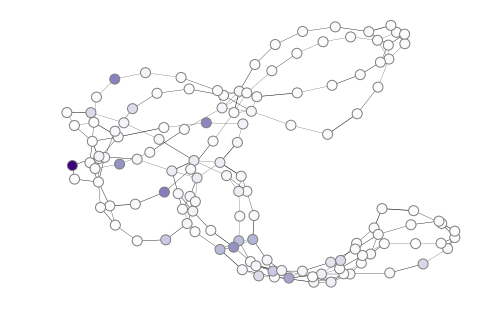

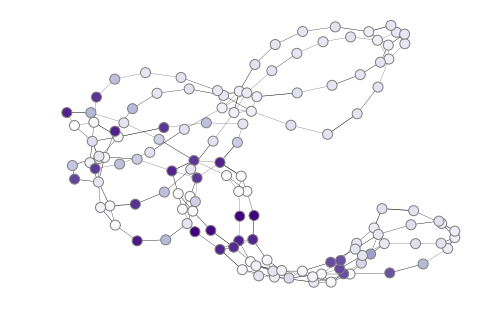

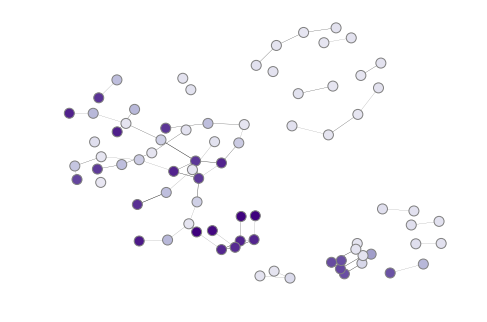

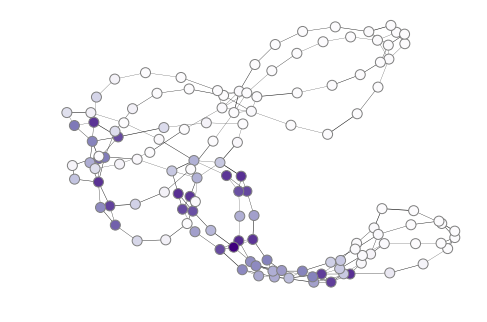

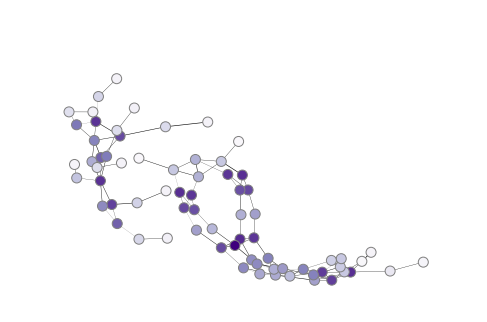

In [157]:
# graph_pos, graph_neg = [], []
edgecolors = [0.5, 0.5, 0.5, 0.1] #np.zeros(3)
cmap = 'Purples'

def plot_pooled(index, alpha, thresh):
    fig = plt.figure()
    A = data_test.adj_list[index].copy()
    idx = np.where(alpha[index] > thresh)[0]    
    n = len(idx)
    A = A[:,idx][idx, :]
    G = nx.from_numpy_array(A)
    pos_new = {}
    for j in range(len(idx)):
        pos_new[j] = pos[idx[j]] #+ np.array([0, -0.1])        
    
    idx_d = np.where(alpha[index] <= thresh)[0]
    if len(idx_d) > 0:            
        G_dummy = nx.from_numpy_array(data_test.adj_list[index][:,idx_d][idx_d, :])
        pos_dummy = {}
        for j in range(len(idx_d)):
            pos_dummy[j] = pos[idx_d[j]]        
        nx.draw(G_dummy, pos_dummy, node_color=np.ones((len(pos_dummy), 3)), edge_color='w',
                               node_size=100, width=0, alpha=0)
        
    vmin = alpha[index].min()
    vmax = alpha[index].max()
    colors = alpha[index].copy()[idx]
    nx.draw(G, pos_new, node_color=colors, node_size=100, with_labels=False, width=A.sum(1) / 10.,
                     edgecolors=edgecolors, cmap=cmap, vmin=vmin, vmax=vmax)
    
    return n
    
for index in [437]:#range(len(data_test.adj_list)):
    A, G, pos = get_graph(data_test, index, draw=False)
    n = A.shape[0]    
    idx_d = np.where(alpha_wsup[index] <= thresh)[0]
    label = data_test.labels[index]    
    r = len(idx_d) / float(n) * 100
    pred = pred_wsup[index]
    if label == pred:
        sfx = 'pos'
#         graph_pos.append((A, alpha_wsup[index], label))
    else:
        sfx = 'neg'
#         graph_neg.append((A, alpha_wsup[index], label))
    
    print(index, sfx, label, pred)
    
    fig = plt.figure()
    nx.draw(G, pos, node_size=100, node_color=attn_WS[index], #graph_pos[0][1], 
            edgecolors=edgecolors, width=A.sum(1) / 10., cmap=cmap)    
    plt.savefig('images/proteins/wsup/label%d/%s/%d_%d_%dnodes_%d_%d_global.pdf' % 
                (label, sfx, r, index, n, label, pred_global[index]))
    plt.show()
    

    
    fig = plt.figure()
    nx.draw(G, pos, node_size=100, node_color=alpha_unsup[index], #graph_pos[0][1], 
            edgecolors=edgecolors, width=A.sum(1) / 10., cmap=cmap)    
    plt.savefig('images/proteins/wsup/label%d/%s/%d_%d_%dnodes_%d_%d_unsup.pdf' % 
                (label, sfx, r, index, n, label, pred_unsup[index]))
    plt.show()
    
    n = plot_pooled(index, alpha_unsup, thresh_unsup)
    plt.axis('off')
    plt.savefig('images/proteins/wsup/label%d/%s/%d_%d_%dnodes_%d_%d_unsup_pooled.pdf' % (label, sfx, r, 
                                                                                    index, n, label, pred_unsup[index]))
    
        
    fig = plt.figure()
    nx.draw(G, pos, node_size=100, node_color=alpha_wsup[index], #graph_pos[0][1], 
            edgecolors=edgecolors, width=A.sum(1) / 10., cmap=cmap)    
    plt.savefig('images/proteins/wsup/label%d/%s/%d_%d_%dnodes_%d_%d.pdf' % (label, sfx, r, 
                                                                             index, n, label, pred))
    plt.show()
    
    n = plot_pooled(index, alpha_wsup, thresh)
    plt.axis('off')
    plt.savefig('images/proteins/wsup/label%d/%s/%d_%d_%dnodes_%d_%d_pooled.pdf' % (label, sfx, r, 
                                                                                    index, n, label, pred_wsup[index]))
#     plt.savefig('images/proteins/wsup/label%d/%s/%d_pooled_%dnodes.png' % (label, sfx, index, n), 
#                 dpi=300, transparent=True)
    plt.show()
# len(graph_pos), len(graph_neg)

# COLLAB

In [108]:
# /export/mlrg/bknyazev/projects/XAI/Model/graph_examples/results/collab/attention_35/wsup_0.5/K3_f64_64_64_lr0.001_proj6/sup_p0.002_K3_f64_50epochs_shape_split_35nodes_lr0.001_seed127.log
model = load_model('/mnt/data/bknyazev//checkpoints/checkpoint_COLLAB_GPU8_117099_fold0_epoch50.pth.tar', 492, 493, 3)

[array([3]), array([3]), array([3])] concat 35 [32]
ChebyshevLayer torch.Size([64, 1479]) tensor([0.5886, 0.5741, 0.5766, 0.5779, 0.5787, 0.5721, 0.5828, 0.5785, 0.5809,
        0.5803, 0.5832, 0.5708, 0.5861, 0.5792, 0.5771, 0.5768, 0.5707, 0.5780,
        0.5751, 0.5808, 0.5667, 0.5771, 0.5871, 0.5892, 0.5734, 0.5801, 0.5843,
        0.5585, 0.5789, 0.5769, 0.5730, 0.5752, 0.5939, 0.5784, 0.5869, 0.5706,
        0.5862, 0.5793, 0.5725, 0.5784, 0.5806, 0.5880, 0.5841, 0.5861, 0.5824,
        0.5769, 0.5810, 0.5912, 0.5799, 0.5755, 0.5884, 0.5794, 0.5656, 0.5694,
        0.5823, 0.5643, 0.5741, 0.5738, 0.5825, 0.5784, 0.5688, 0.5787, 0.5752,
        0.5829], grad_fn=<NormBackward1>)
0 0 ['no', '0.002']
ChebyshevLayer torch.Size([64, 192]) tensor([0.5827, 0.5569, 0.5622, 0.5791, 0.5911, 0.5927, 0.5870, 0.5947, 0.5708,
        0.5683, 0.6016, 0.5696, 0.5883, 0.5586, 0.5903, 0.5824, 0.5677, 0.5797,
        0.6254, 0.6108, 0.5444, 0.5602, 0.5643, 0.5650, 0.5917, 0.5827, 0.5587,
        0.6

/export/mlrg/bknyazev/projects/XAI/Model/graph_examples/models.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/export/mlrg/bknyazev/anaconda2/envs/py3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/export/mlrg/bknyazev/anaconda2/envs/py3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/export/mlrg/bknyazev/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/export/mlrg/bknyazev/anaconda2/envs/py3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/export/mlrg/bknyazev/anaconda2

In [109]:
datareader = graphdata.DataReader(data_dir='/mnt/data/bknyazev/data/graph_data/COLLAB',
                            rnd_state=np.random.RandomState(127),
                            folds=1,
                            N_nodes=35,
                            use_cont_node_attr=False)
data_train = graphdata.GraphData(0,
                 datareader,
                 shuffle_nodes=False,
                 batch_size=32,
                 split='train_val')
data_test = graphdata.GraphData(0,
                 datareader,
                 shuffle_nodes=False,
                 batch_size=32,
                 split='test')

loading data from /mnt/data/bknyazev/data/graph_data/COLLAB/data.pkl
5000 681 35
good
degree_max 491
node shuffling is off
TRAIN_VAL: 500/5000
train_val: N_nodes_min: 32
train_val: N_nodes_max: 35
train_val, Class 0: 			227 samples
train_val, Class 1: 			125 samples
train_val, Class 2: 			148 samples
node shuffling is off
TEST: 4500/5000
test: N_nodes_min: 32
test: N_nodes_max: 492
test, Class 0: 			2373 samples
test, Class 1: 			650 samples
test, Class 2: 			1477 samples


(35, 1) (35, 35)


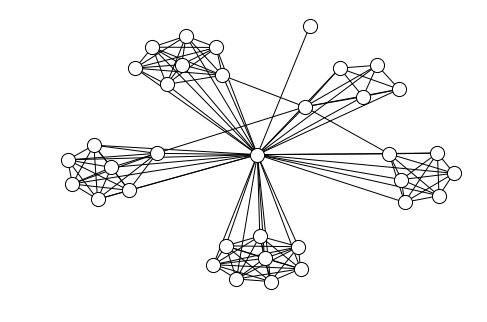

label 1


In [141]:
index = 3
A, G, pos = draw_graph(data_test, index)

In [142]:
n = N_nodes = A.shape[0]
D = np.sum(A, 1, keepdims=True)  # N,1  as in  [M. Simonovsky et al., CVPR'2017]
D_onehot = np.zeros((N_nodes, 491 + 1))
D_onehot[np.arange(N_nodes), D.astype(np.int).squeeze()] = 1
print(D_onehot.shape, data_test.features_onehot[index].shape)
data = (torch.from_numpy(np.concatenate((data_test.features_onehot[index], D_onehot), axis=1)).unsqueeze(0).float().to(device).expand(2, -1, -1),
            None,
            torch.from_numpy(A).unsqueeze(0).unsqueeze(3).float().to(device).to(device).expand(2, -1, -1, -1),
            {'graph_support': torch.ones(2, n).float().to(device).to(device),
             'N_nodes': torch.zeros(2, 1).long().to(device) + n,
             'signal_attn': torch.zeros(2, n).float().to(device)})
y, output = model(data)[:2]
print(y, output[1][0].shape)
alpha = output[1][0][0, :].data.numpy()

(35, 492) (35, 1)
tensor([[ 1.2335,  2.3339, -3.6476],
        [ 1.2335,  2.3339, -3.6476]], grad_fn=<ThAddmmBackward>) torch.Size([2, 35])


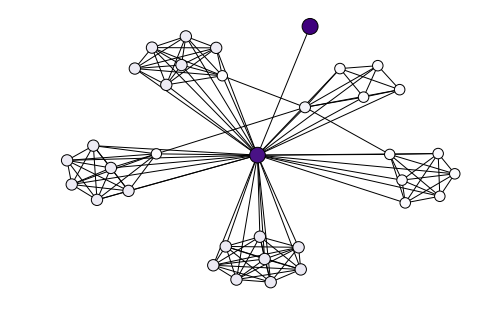

In [143]:
nx.draw(G, pos, node_color=alpha, node_size= (alpha + 0.1) * 1000, edgecolors=np.zeros(3), cmap='Purples')
plt.show()

# D&D

In [155]:
# /export/mlrg/bknyazev/projects/XAI/Model/graph_examples/results/collab/attention_35/wsup_0.5/K3_f64_64_64_lr0.001_proj6/sup_p0.002_K3_f64_50epochs_shape_split_35nodes_lr0.001_seed127.log
model = load_model('/mnt/data/bknyazev//checkpoints/checkpoint_DD_GPU9_622565_fold0_epoch50.pth.tar', 5748, 89, 2)

/export/mlrg/bknyazev/projects/XAI/Model/graph_examples/models.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/export/mlrg/bknyazev/anaconda2/envs/py3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/export/mlrg/bknyazev/anaconda2/envs/py3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/export/mlrg/bknyazev/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/export/mlrg/bknyazev/anaconda2/envs/py3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/export/mlrg/bknyazev/anaconda2

[array([3]), array([3]), array([3])] concat 300 [32]
ChebyshevLayer torch.Size([64, 267]) tensor([0.5671, 0.5945, 0.5651, 0.5932, 0.5611, 0.5540, 0.5746, 0.5625, 0.5783,
        0.5902, 0.5905, 0.5724, 0.5538, 0.5935, 0.5782, 0.5822, 0.5799, 0.5635,
        0.5610, 0.5728, 0.5944, 0.5702, 0.5664, 0.5506, 0.5523, 0.5883, 0.5909,
        0.6036, 0.5684, 0.5624, 0.5717, 0.5632, 0.5705, 0.5614, 0.5892, 0.5818,
        0.5856, 0.5923, 0.5968, 0.5674, 0.5938, 0.5752, 0.5588, 0.5823, 0.5453,
        0.5796, 0.5763, 0.5782, 0.5918, 0.5556, 0.5834, 0.5601, 0.5980, 0.5718,
        0.5755, 0.5415, 0.5699, 0.5847, 0.5836, 0.6141, 0.5749, 0.5543, 0.6016,
        0.5759], grad_fn=<NormBackward1>)
0 0 ['no', '0.01']
ChebyshevLayer torch.Size([64, 192]) tensor([0.5742, 0.5793, 0.5827, 0.5645, 0.5934, 0.5804, 0.5891, 0.5982, 0.5285,
        0.5843, 0.5728, 0.6097, 0.6042, 0.5500, 0.5408, 0.5791, 0.5858, 0.5431,
        0.6081, 0.5666, 0.5839, 0.5631, 0.5997, 0.5800, 0.5913, 0.5927, 0.5660,
        0.58

In [156]:
datareader = graphdata.DataReader(data_dir='/mnt/data/bknyazev/data/graph_data/DD',
                            rnd_state=np.random.RandomState(726),
                            folds=1,
                            N_nodes=300,
                            use_cont_node_attr=False)
data_train = graphdata.GraphData(0,
                 datareader,
                 shuffle_nodes=False,
                 batch_size=32,
                 split='train_val')
data_test = graphdata.GraphData(0,
                 datareader,
                 shuffle_nodes=False,
                 batch_size=32,
                 split='test')

loading data from /mnt/data/bknyazev/data/graph_data/DD/data.pkl
1178 740 300
good
degree_max 19
node shuffling is off
TRAIN_VAL: 500/1178
train_val: N_nodes_min: 30
train_val: N_nodes_max: 300
train_val, Class 0: 			215 samples
train_val, Class 1: 			285 samples
node shuffling is off
TEST: 678/1178
test: N_nodes_min: 30
test: N_nodes_max: 5748
test, Class 0: 			476 samples
test, Class 1: 			202 samples


(182, 89) (182, 182)


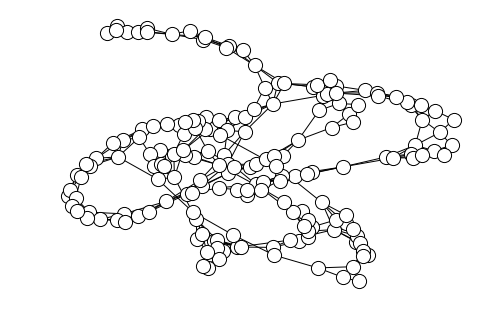

label 1


In [157]:
index = 0
A, G, pos = draw_graph(data_test, index)

In [158]:
n = A.shape[0]
data = (torch.from_numpy(data_test.features_onehot[index]).unsqueeze(0).float().to(device).expand(2, -1, -1),
            None,
            torch.from_numpy(A).unsqueeze(0).unsqueeze(3).float().to(device).to(device).expand(2, -1, -1, -1),
            {'graph_support': torch.ones(2, n).float().to(device).to(device),
             'N_nodes': torch.zeros(2, 1).long().to(device) + n,
             'signal_attn': torch.zeros(2, n).float().to(device)})
y, output = model(data)[:2]
print(y, output[1][0].shape)
alpha = output[1][0][0, :].data.numpy()

tensor([[-0.1876,  0.3212],
        [-0.1876,  0.3212]], grad_fn=<ThAddmmBackward>) torch.Size([2, 182])


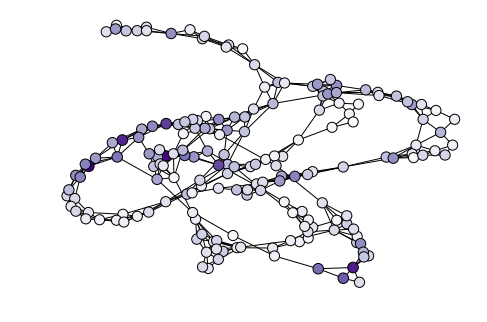

In [159]:
nx.draw(G, pos, node_color=alpha, node_size=(alpha + 0.1) * 1000, edgecolors=np.zeros(3), cmap='Purples')
plt.show()

## Show correctly and incorrectly classified samples